In [1]:
using Pkg
Pkg.add("Images")
Pkg.add("MAT")

using MAT
using Plots
using Images


pyplot()

file = matopen("project_data.mat")
img = read(file, "im")
sources = read(file,"sources")
rgb = read(file,"rgb")
close(file)

    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`


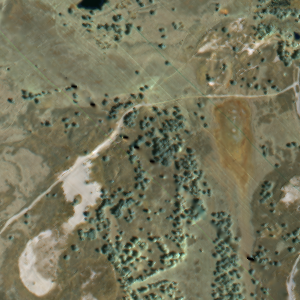

In [2]:
# visualize data in rgb (using bands 67,109,141 as th RGB channels)
p1 = colorview(RGB,permutedims(rgb,(3,1,2))) # convert 3d array to the image format used by julia

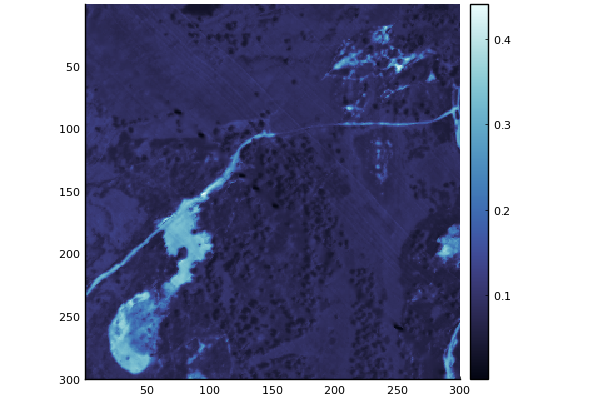

In [3]:
#visualize a spectral band on its own
p2 = heatmap(img[:,:,15],aspect_ratio=1, yflip = true,c=:ice)

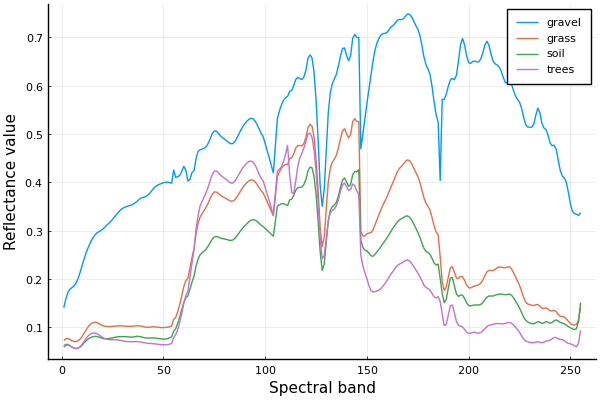

In [4]:
# visualize the endmembers to be used

plot(sources[:,1],label = "gravel")
plot!(sources[:,2],label = "grass")
plot!(sources[:,3],label = "soil")
plot!(sources[:,4],label = "trees")
xlabel!("Spectral band")
ylabel!("Reflectance value")

# Unmixing the image

The model we are using to decompose the image into the sum of the contributions of the endmembers is:

\begin{equation*}
\mathbf{X} = \mathbf{S}\mathbf{A} + \mathbf{E} 
\end{equation*}

 $\mathbf{X}\in \mathbb{R}^{L\times N}$ : data matrix
 
 $\mathbf{S}\in \mathbb{R}^{L\times P}$ : endmember matrix
 
 $\mathbf{A}\in \mathbb{R}^{P\times N}$ : abundance matrix
 
 $\mathbf{E}\in \mathbb{R}^{L\times N}$ : additive noise matrix
 
 where $L$ is the number of spectral bands, $P$ is the number of materials, and $N$ is the number of pixels
 
 The hyperspectral image is represented as a matrix with $N$ pixels, so the first thing to do is to reshape the image to a big matrix.

We can try and estimate the abundance matrix using a least squares formulation:

\begin{equation*}
\hat{A} = \underset{\mathbf{A}>\mathbf{0}, \mathbf{1}_{P}^T \mathbf{A} = \mathbf{1}_{N}^{T} }{\textrm{arg min}}\frac{1}{2}||\mathbf{X}-\mathbf{SA}||_{F}^{2} = \underset{\mathbf{A}>\mathbf{0}, \mathbf{1}_{P}^T \mathbf{A} = \mathbf{1}_{N}^{T} }{\textrm{arg min}}\frac{1}{2} \sum_{i=1}^{N} ||\mathbf{x}_{n}-\mathbf{S}\mathbf{a}_{n}||_{2}^{2}
\end{equation*}

where $\mathbf{1}_{.}$ is a vector of ones whose size is given in index 

Choose an algorithm to solve the optimization problem, and implement it both in a serial version and a version parallelized across the pixels.

In [5]:
using LinearAlgebra
f(S,A,X) = 1/2 * norm(X - S*A,2)
∇f(S,A,X)  = -2 * transpose(S)*(S*A - X) # I only take a derivative with respect to A because I believe it's the only variable


∇f (generic function with 1 method)

In [6]:
function cost(S,A,X)
    sum = 0
    for k=1:size(A,3)
        x_n = Iterators.flatten(img_small[:,:,k])
        a_n = Iterators.flatten(img_small[:,:,k])
        sum+= norm(x_n - S*a_n)
    end
    
    return 1/2*sum    
end

cost (generic function with 1 method)

In [7]:
N = 100*100
A = zeros(4, N)

img_small = img[1:100,1:100,:]; # use a small crop of the image first


print(size(sources))


img_small_flatt = reshape(img_small, 255, N)
print(size(img_small_flatt))

res = f(sources, A, img_small_flatt)
print("\n")
print(res)


res2 = ∇f(sources, A, img_small_flatt)
print("\n")
print(size(res2))

(255, 4)(255, 10000)
210.3174060320492
(4, 10000)

In [8]:
# Backtracking
#-------------
function backtracking(A,S,X,f,∇f,d)
    """
    bactracking: 
    see e.g. https://web.stanford.edu/~boyd/cvxbook/bv_cvxbook.pdf - p.464
    IN:
    ---
    x: initial point
    f, ∇f: function to be minimized and its gradient
    d: searc direction
    OUT:
    ----
    y: final point
    n: number of loops
    """
    nb_const   = 0 # number of loops
    step_size = 1
    beta = 0.7
    alpha = 0.9
    new_f = f(S,A + step_size*d,X)
    condition = f(S,A,X) + alpha*transpose(∇f(S,A,X))*step_size*d
    while new_f > condition
        nb_const = nb_const + 1
        step_size = step_size * beta
        new_f = f(S,A + step_size*d, X)
        condition = f(S,A,X) + alpha*step_size*transpose(∇f(S,A,X))*d
    end
    return step_size,nb_const
end


backtracking (generic function with 1 method)

In [ ]:
### Serial version of the algorithm
img_small = img[1:100,1:100,:]; # use a small crop of the image first
print(size(img_small))
img_small_flatt = reshape(img_small, 255, N)
p = 4
N = 100 * 100
step_size = 0.1
nb_it = 0

A = rand(4, N)

while nb_it < 100
    #find active constraints. In a first approximation, there is no constraints. So it's a standard gradient descent
    nb_it = nb_it + 1
    
    d = ∇f(sources, A, img_small_flatt)
    #step_size,nb_const = backtracking(A,sources,img_small_flatt,f,∇f,d)
    A = A - step_size * d
    
end

print(size(A))
print("\n")
print(A)

In [3]:
new_img = reshape(sources*A,100,100,255)[:,:,15]
p2 = heatmap(new_img,aspect_ratio=1, yflip = true,c=:ice)

LoadError: UndefVarError: sources not defined